In [201]:
import pandas as pd 
import numpy as np 
import pybaseball as pyball
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

pd.set_option('display.max_columns', None)  # Show all columns


### THE GRAPHS 

In this notebook I want to mess around with different ways to present a pitchers aresenal. My goal with these visualizations is to get a better understanding of what a pitcher is up there throwing. 

We need a player to experiment on, when not Zach Eflin, the starting pitcher for the Baltimore Orioles during the BlueJays 2025 home opener. 

In [215]:
#The data 

#Set whatever date range you want!! 
start = '2024-03-20'
end = '2024-9-30'

#Player Name
last = 'Francis'
first = 'Bowden'

#Get Player ID
id = int(pyball.playerid_lookup(last, first)['key_mlbam'].values[0])

pbp_data = pyball.statcast_pitcher(start, end, id)
php_data = pbp_data[pbp_data['game_type'] == 'R']
pbp_data['count'] = pbp_data['balls'].astype(str) + '-' + pbp_data['strikes'].astype(str)

pbp_data.head(5)

Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,count
0,FF,2024-09-24,92.4,-2.14,5.94,"Francis, Bowden",678882,670102,field_out,hit_into_play,NaN,NaN,NaN,NaN,12.0,Ceddanne Rafaela flies out to right fielder Ge...,R,R,R,TOR,BOS,X,9.0,fly_ball,0,2,2024,-0.24,1.52,0.30,3.53,NaN,687093.0,NaN,2,5,Top,194.44,77.27,NaN,NaN,NaN,NaN,6.773638,-134.434335,-3.638780,-4.408741,29.980278,-13.117642,3.4,1.59,345.0,94.4,30.0,92.8,2337.0,6.6,744876,672386,687462,676914,680718,676391,664770,694388,543807,53.91,0.154,0.246,0.0,1.0,0.0,0.0,3.0,34,5,4-Seam Fastball,2,0,0,2,0,2,0,2,Infield shade,Standard,214.0,0.039,-0.194,NaN,NaN,0.442,0.194,94.4,2,-2,0.781,0.219,28,23,28,24,2,1,6.0,1.0,NaN,3.0,1.15,0.24,0.24,40.1,0-2
1,SL,2024-09-24,79.1,-2.13,6.02,"Francis, Bowden",678882,670102,NaN,foul,NaN,NaN,NaN,NaN,4.0,Ceddanne Rafaela flies out to right fielder Ge...,R,R,R,TOR,BOS,S,NaN,NaN,0,2,2024,0.57,-0.49,-0.46,2.37,NaN,687093.0,NaN,2,5,Top,NaN,NaN,NaN,NaN,NaN,NaN,2.593338,-115.286685,-0.273970,4.632545,21.057983,-36.710995,3.4,1.59,5.0,80.6,-25.0,80.0,2484.0,6.8,744876,672386,687462,676914,680718,676391,664770,694388,543807,53.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,4,Slider,2,0,0,2,0,2,0,2,Infield shade,Standard,68.0,0.000,0.000,69.4,7.2,NaN,0.000,88.0,2,-2,0.781,0.219,28,23,28,24,2,1,6.0,1.0,NaN,3.0,4.12,-0.57,-0.57,44.2,0-2
2,FF,2024-09-24,90.2,-2.21,5.88,"Francis, Bowden",678882,670102,NaN,foul,NaN,NaN,NaN,NaN,11.0,Ceddanne Rafaela flies out to right fielder Ge...,R,R,R,TOR,BOS,S,NaN,NaN,0,2,2024,-0.26,1.54,-0.27,3.66,NaN,687093.0,NaN,2,5,Top,NaN,NaN,NaN,NaN,NaN,NaN,5.412399,-131.225642,-2.842284,-4.122131,28.186042,-14.051622,3.4,1.59,71.0,71.9,80.0,90.8,2312.0,6.7,744876,672386,687462,676914,680718,676391,664770,694388,543807,53.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,3,4-Seam Fastball,2,0,0,2,0,2,0,2,Infield shade,Standard,201.0,0.000,0.000,66.4,6.8,NaN,0.000,88.0,2,-2,0.781,0.219,28,23,28,24,2,1,6.0,1.0,NaN,3.0,1.27,0.26,0.26,39.2,0-2
3,FF,2024-09-24,91.4,-2.13,5.86,"Francis, Bowden",678882,670102,NaN,foul,NaN,NaN,NaN,NaN,14.0,Ceddanne Rafaela flies out to right fielder Ge...,R,R,R,TOR,BOS,S,NaN,NaN,0,1,2024,-0.20,1.59,1.10,2.09,NaN,687093.0,NaN,2,5,Top,NaN,NaN,NaN,NaN,NaN,NaN,8.613474,-132.775538,-7.072400,-4.282070,28.796512,-11.940112,3.4,1.59,209.0,70.8,41.0,91.8,2406.0,6.6,744876,672386,687462,676914,680718,676391,664770,694388,543807,53.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,2,4-Seam Fastball,2,0,0,2,0,2,0,2,Infield shade,Standard,209.0,0.000,-0.067,62.5,7.9,NaN,0.067,88.0,2,-2,0.781,0.219,28,23,28,24,2,1,6.0,1.0,NaN,3.0,1.15,0.20,0.20,38.0,0-1
4,CU,2024-09-24,73.5,-2.09,5.97,"Francis

In [216]:
#Pitch distribution
pitch_counts = pbp_data['pitch_name'].value_counts().to_dict()

pitch_counts_LHB = pbp_data[pbp_data['stand'] == 'L']
pitch_counts_LHB = pitch_counts_LHB['pitch_name'].value_counts().to_dict()

pitch_counts_RHB = pbp_data[pbp_data['stand'] == 'R']
pitch_counts_RHB = pitch_counts_RHB['pitch_name'].value_counts().to_dict()

In [217]:
pitch_counts

{'4-Seam Fastball': 797,
 'Split-Finger': 287,
 'Curveball': 283,
 'Slider': 143,
 'Sinker': 48}

In [218]:
pitch_counts_LHB

{'4-Seam Fastball': 379,
 'Split-Finger': 206,
 'Curveball': 129,
 'Slider': 8,
 'Sinker': 1}

In [219]:
pitch_counts_RHB

{'4-Seam Fastball': 418,
 'Curveball': 154,
 'Slider': 135,
 'Split-Finger': 81,
 'Sinker': 47}

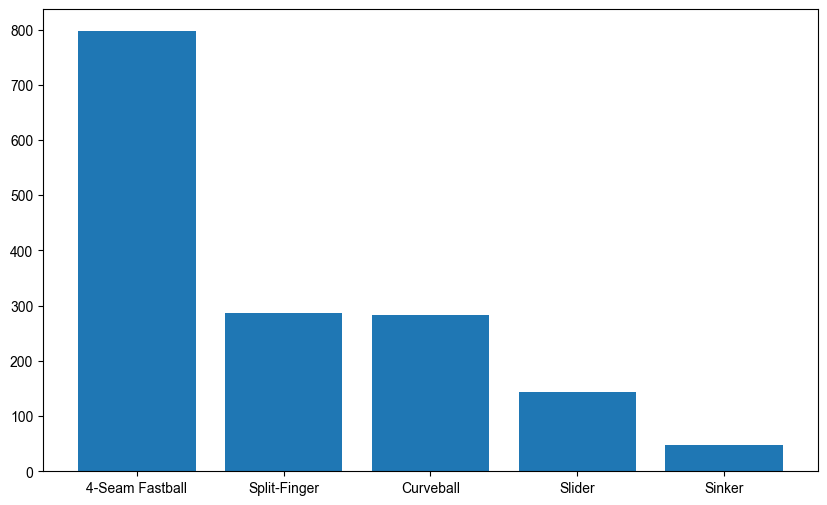

In [220]:
#BAR CHART

plt.figure(figsize=(10, 6))
plt.bar(pitch_counts.keys(), pitch_counts.values())





plt.show()

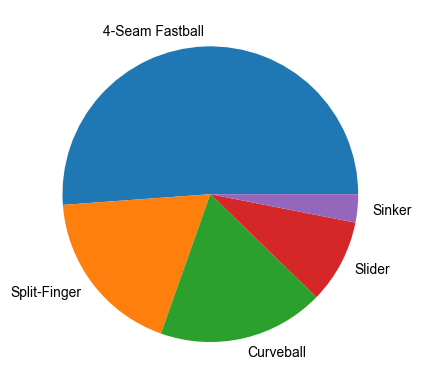

In [221]:
#PIE CHART 

plt.pie(pitch_counts.values(), labels = pitch_counts.keys())


plt.show()





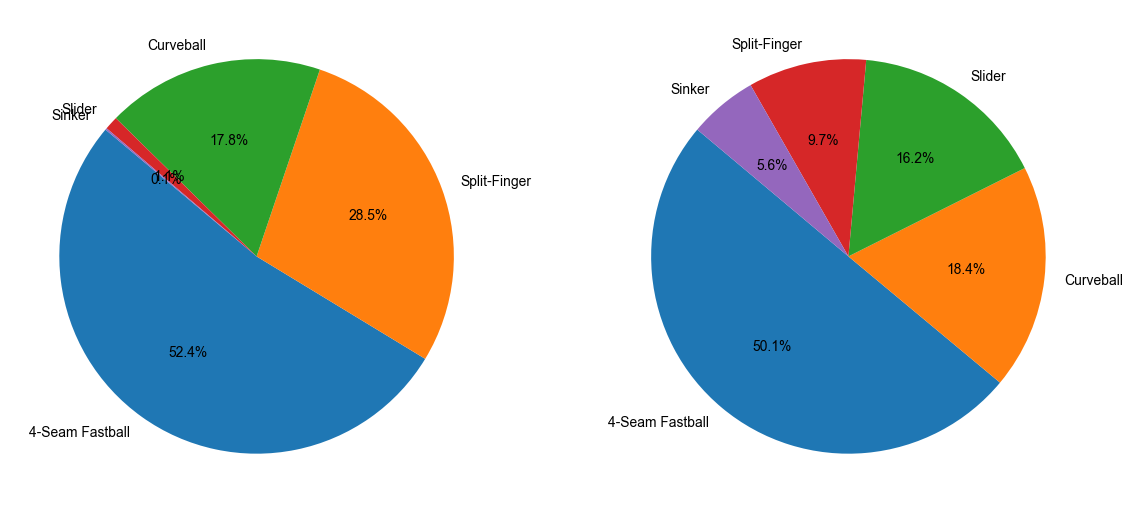

In [222]:
#Compare RHB vs LHB 

fig, axes = plt.subplots(1,2, figsize=(14,7))

axes[0].pie(
    pitch_counts_LHB.values(),
    labels = pitch_counts_LHB.keys(),
    autopct = '%1.1f%%',
    startangle = 140
)

axes[1].pie(
    pitch_counts_RHB.values(),
    labels = pitch_counts_RHB.keys(),
    autopct = '%1.1f%%',
    startangle = 140
)


plt.show()
#kinda sloppy and annoying to makes changes twice, lets see if we can use a loop to make the code cleaner.


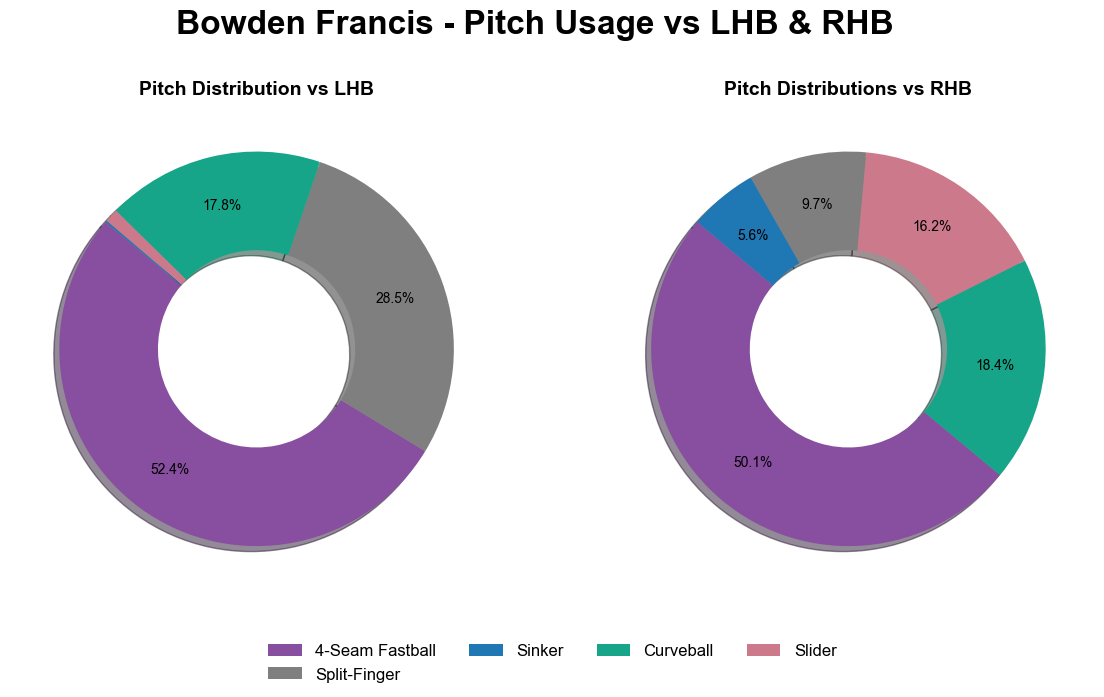

In [223]:
batter_splits = [pitch_counts_LHB, pitch_counts_RHB]
titles = ['Pitch Distribution vs LHB', 'Pitch Distributions vs RHB']

#Pitch colours need to be consistent so the pies will be easier to read and compare 
pitch_colors = {
    'Sinker': '#1f77b4',       
    'Cutter': '#d4ac0d',      
    'Curveball': '#17a589',    
    'Sweeper': '#7d6608',     
    '4-Seam Fastball': '#884ea0',  
    'Changeup': '#a93226',    
    'Slider': '#CC7A8B',       
    'Other': '#7f7f7f'         
}
#change font for fun
plt.rcParams['font.family'] = 'Arial'


def autopct_threshold(pct, threshold=2):
    return f'{pct:.1f}%' if pct > threshold else ''

fig, axes = plt.subplots(1,2, figsize = (14,7))

for ax, pitch_data, title in zip(axes, batter_splits, titles):

    labels = list(pitch_data.keys())
    colours = [pitch_colors.get(pitch, pitch_colors['Other']) for pitch in labels]

    ax.pie(
        pitch_data.values(), 
        startangle = 140,
        autopct =lambda pct: autopct_threshold(pct, threshold=3),
        labeldistance=1.1,
        colors = colours,
        pctdistance = 0.75,
        wedgeprops=dict(width=0.5), 
        shadow = True   
    )
    ax.set_title(title, fontsize = 14, fontweight='bold')


# Get all unique pitch types used across both LHB and RHB
all_pitches = set(pitch_counts_LHB.keys()) | set(pitch_counts_RHB.keys())
legend_elements = [
    Patch(facecolor = pitch_colors.get(pitch, pitch_colors['Other']), label=pitch)
    for pitch in all_pitches
]

# Add the legend to the figure (not one of the axes)
fig.legend(
    handles = legend_elements,
    loc='lower center',  
    ncol = 4,              
    fontsize = 12,
    frameon = False
)

main_title = first + ' ' + last + ' - Pitch Usage vs LHB & RHB' 
fig.suptitle(main_title, fontsize = 24, fontweight = 'bold')
plt.show()


Amazing! I quite like how the pie charts are looking so far. The next steps to make this even more helpful is to add a sort of filter. I want to be able to select the count in order to see how a pitcher might change their attack based on being behind or ahead in the count and so on. 

I will now need to convert my code above into a plotting function. This will allow me to use some sort of GUI to use a drop down menu to be one of the inputs of the function, in this case the count. The count input will then be used to filter the data shown in the graph. 

In [229]:
#Filter data based on count
def count_filter(pbp_data, counts): 

    #Count filters, can change later if needed. 
    hitters_count = ['1-0', '2-0', '3-1', '3-0']
    pitchers_count = ['1-2', '0-2']
    even_count = ['0-0', '1-1']

    print("hello")
    if counts == 'All':
        return pbp_data
    elif counts == 'Ahead':
        return pbp_data[pbp_data['count'].isin(pitchers_count)]
    elif counts == 'Behind': 
        return pbp_data[pbp_data['count'].isin(hitters_count)]
    elif counts == 'Even': 
        return pbp_data[pbp_data['count'].isin(even_count)]
    else:
        return pbp_data[pbp_data['count'] == counts]
    

#Percent for pie slice
def autopct_threshold(pct, threshold=2):
    return f'{pct:.1f}%' if pct > threshold else ''

#Return total amount if pitch type thrown
def pitchSums(pbp_data, stand = None):
    if stand == None: 
        return pbp_data['pitch_name'].value_counts().to_dict()
    else:
        pitches = pbp_data[pbp_data['stand'] == stand]
        return pitches['pitch_name'].value_counts().to_dict()


#Plot two pie charts showing batter spits 
def plot_pitchDist(data, count):

    data = count_filter(pbp_data = data, counts = count)
    batter_splits = [pitchSums(data, stand = 'L'), pitchSums(data, stand = 'R')]

    
    titles = ['Pitch Distribution vs LHB', 'Pitch Distributions vs RHB']

    #Pitch colours need to be consistent so the pies will be easier to read and compare 
    pitch_colors = {
        'Sinker': '#1f77b4',       
        'Cutter': '#d4ac0d',      
        'Curveball': '#17a589',    
        'Sweeper': '#7d6608',     
        '4-Seam Fastball': '#884ea0',  
        'Changeup': '#a93226',    
        'Slider': '#CC7A8B',
        'Split-Finger': '#8c564b',     
        'Other': '#7f7f7f'         
    }
    #change font for fun
    plt.rcParams['font.family'] = 'Arial'

    fig, axes = plt.subplots(1,2, figsize = (14,7))

    for ax, pitch_data, title in zip(axes, batter_splits, titles):

        labels = list(pitch_data.keys())
        colours = [pitch_colors.get(pitch, pitch_colors['Other']) for pitch in labels]

        ax.pie(
            pitch_data.values(), 
            startangle = 140,
            autopct =lambda pct: autopct_threshold(pct, threshold=3),
            labeldistance=1.1,
            colors = colours,
            pctdistance = 0.75,
            wedgeprops=dict(width=0.5), 
            shadow = True   
        )
        ax.set_title(title, fontsize = 14, fontweight='bold')


    # Get all unique pitch types used across both LHB and RHB
    all_pitches = set(pitch_counts_LHB.keys()) | set(pitch_counts_RHB.keys())
    legend_elements = [
        Patch(facecolor = pitch_colors.get(pitch, pitch_colors['Other']), label=pitch)
        for pitch in all_pitches
    ]

    # Add the legend to the figure (not one of the axes)
    fig.legend(
        handles = legend_elements,
        loc='lower center',  
        ncol = 4,              
        fontsize = 12,
        frameon = False
    )

    main_title = first + ' ' + last + ' - Pitch Usage vs LHB & RHB' 
    fig.suptitle(main_title, fontsize = 24, fontweight = 'bold')
    plt.show()

hello


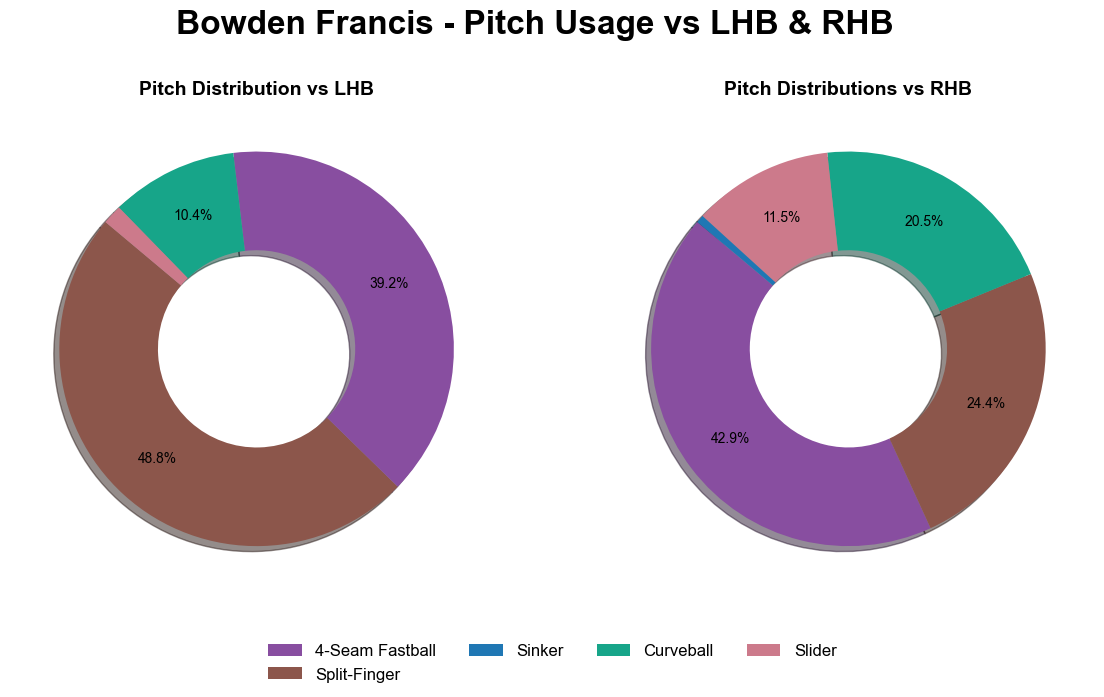

In [230]:
plot_pitchDist(pbp_data, count = 'Ahead')

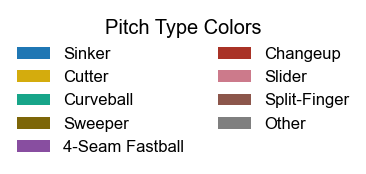

In [237]:
# Create dummy figure
fig, ax = plt.subplots(figsize=(4, 2))

# Hide axes
ax.axis('off')

# Create a list of legend patches using the pitch_colors
legend_handles = [Patch(facecolor=color, label=pitch) for pitch, color in pitch_colors.items()]

# Add the legend
legend = ax.legend(
    handles=legend_handles,
    title='Pitch Type Colors',
    loc='center',
    fontsize='large',
    title_fontsize='x-large',
    frameon=False,
    ncol=2 
)

plt.show()